# **Deploying Anomaly Detection Model**


Final Project

DS6013 - Data Products

UVG Masters

Team # 1

William Chavarría </br>
Pablo Armas </br>
André Rodas </br>
Francisco Manjon </br>


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
                             

## Load Data

In [2]:
# Read the CSV file and select only the desired columns
cols_to_read = ['date', 't1', 't2', 't3', 't4', 'h3', 'h4', 'f1', 'f2', 'truth']
data = pd.read_csv('parroquia.csv', usecols=cols_to_read, parse_dates=['date'])

In [3]:
data.shape

(464, 10)

In [4]:
# Display the first rows of the DataFrame
data.head()


,date,t1,t2,t3,t4,h3,h4,f1,f2,truth
0,2020-07-26 16:01:43+00:00,17.6,23.6,23.7,25.0,69.5,85.6,35.39,34.21,1
1,2020-07-26 16:04:56+00:00,16.4,23.3,23.7,24.9,69.3,84.4,39.49,39.33,1
2,2020-07-26 16:08:10+00:00,14.7,23.2,23.8,25.2,74.8,89.7,38.72,41.62,1
3,2020-07-26 16:11:28+00:00,16.3,23.9,24.0,25.5,77.0,91.0,39.16,39.73,1
4,2020-07-26 16:14:41+00:00,16.9,24.1,24.1,25.6,76.7,90.8,39.19,40.83,1


## Dictionary

| Feature | Class   | Description                                                |
|---------|---------|------------------------------------------------------------|
| date    | date    | Timestamp                                                  |
| t1      | float64 | Temperature recorded by sensor 1                           |
| t2      | float64 | Temperature recorded by sensor 2                           |
| t3      | float64 | Temperature recorded by sensor 3                           |
| t4      | float64 | Temperature recorded by sensor 4                           |
| h1      | float64 | Relative humidity recorded by sensor 1                     |
| h2      | float64 | Relative humidity recorded by sensor 2                     |
| f1      | float64 | Alternating current (AC) recorded by the sensor in phase 1 |
| f2      | float64 | Alternating current (AC) recorded by the sensor in phase 2 |
| truth   | Int     | True value of whether it is an anomaly or not              |

## EDA

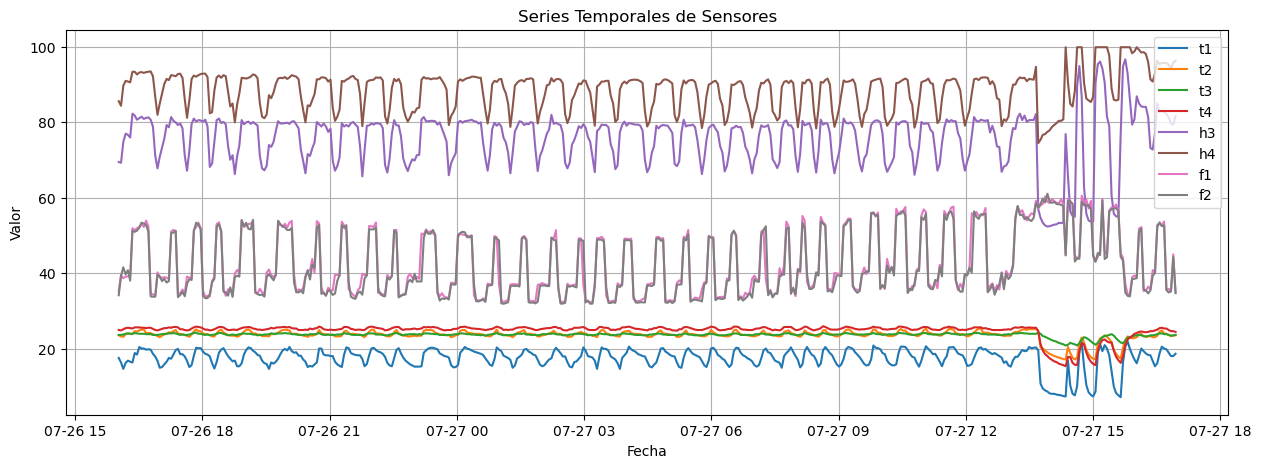

In [5]:
plt.figure(figsize=(15, 5))
for column in data.columns[1:9]:
    plt.plot(data['date'], data[column], label=column)
plt.legend()
plt.title('Series Temporales de Sensores')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

## Prep

In [6]:
# Drop the 'date' column as it's not needed for model training
data_for_training = data.drop(columns=['date', 'truth'])

data_for_training

,t1,t2,t3,t4,h3,h4,f1,f2
0,17.6,23.6,23.7,25.0,69.5,85.6,35.39,34.21
1,16.4,23.3,23.7,24.9,69.3,84.4,39.49,39.33
2,14.7,23.2,23.8,25.2,74.8,89.7,38.72,41.62
3,16.3,23.9,24.0,25.5,77.0,91.0,39.16,39.73
4,16.9,24.1,24.1,25.6,76.7,90.8,39.19,40.83
...,...,...,...,...,...,...,...,...
459,19.9,24.0,23.9,25.4,82.2,95.7,35.67,35.59
460,19.0,23.7,23.7,25.0,81.3,95.3,35.89,34.93
461,18.1,23.4,23.5,24.7,79.7,94.1,35.16,35.31
462,18.1,23.5,23.6,24.7,79.4,95.9,45.04,44.33


## Modeling

In [7]:
# Initialize the Isolation Forest model
# Assuming 15% of the data are anomalies, so contamination is set to 0.15
iso_forest = IsolationForest(contamination=0.15, random_state=42)
iso_forest

IsolationForest(contamination=0.15, random_state=42)

In [8]:
# Fit the model to the data
iso_forest.fit(data_for_training)

IsolationForest(contamination=0.15, random_state=42)

In [9]:
# Predict anomalies in the data
# The model returns 1 for normal data points and -1 for anomalies
data['anomaly'] = iso_forest.predict(data_for_training)


In [10]:
# Count the number of anomalies and normal data points
anomaly_counts = data['anomaly'].value_counts()
print(f"Number of normal data points (1): {anomaly_counts[1]}")
print(f"Number of anomalies (-1): {anomaly_counts[-1]}")

Number of normal data points (1): 394
Number of anomalies (-1): 70


In [11]:
# Calculate the anomaly score for each data point
data['anomaly_score'] = iso_forest.decision_function(data_for_training)

# Display the anomaly scores
print(data[['date', 'anomaly', 'anomaly_score']].head())

                       date  anomaly  anomaly_score
0 2020-07-26 16:01:43+00:00        1       0.058399
1 2020-07-26 16:04:56+00:00        1       0.036144
2 2020-07-26 16:08:10+00:00        1       0.033460
3 2020-07-26 16:11:28+00:00        1       0.053447
4 2020-07-26 16:14:41+00:00        1       0.029194


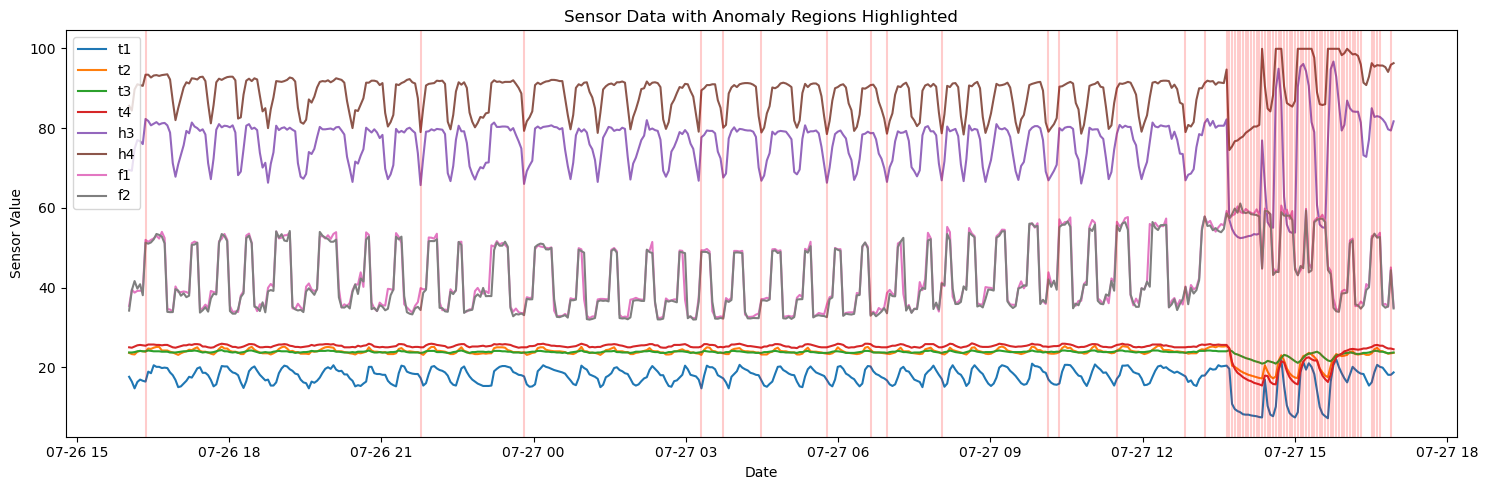

In [15]:
# Plotting the original sensor data with shaded anomaly regions
plt.figure(figsize=(15, 5))

sensors = ['t1', 't2', 't3', 't4', 'h3', 'h4', 'f1', 'f2']
for sensor in sensors:
    plt.plot(data['date'], data[sensor], label=sensor)

anomaly_dates = data[data['anomaly'] == -1]['date']
for anomaly_date in anomaly_dates:
    plt.axvline(x=anomaly_date, color='red', alpha=0.2)

plt.legend()
plt.title('Sensor Data with Anomaly Regions Highlighted')
plt.xlabel('Date')
plt.ylabel('Sensor Value')
plt.tight_layout()

plt.savefig('anomalias.png', dpi=300)


plt.show()


In [16]:
y_pred = data['anomaly']
y_true = data['truth']

In [17]:
report = classification_report(y_true, y_pred)

In [18]:
print(report)

              precision    recall  f1-score   support

          -1       0.76      0.95      0.84        56
           1       0.99      0.96      0.98       408

    accuracy                           0.96       464
   macro avg       0.87      0.95      0.91       464
weighted avg       0.96      0.96      0.96       464



In [19]:
matrix = confusion_matrix(y_true, y_pred, labels=[-1, 1])

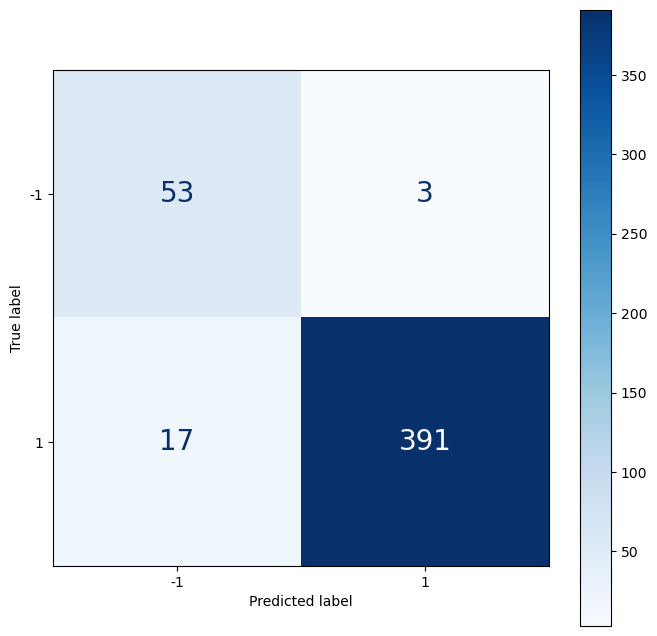

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[-1, 1])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)

for text in ax.texts:
    text.set_size(20)
plt.savefig('anomalias.png', dpi=300)
plt.show()

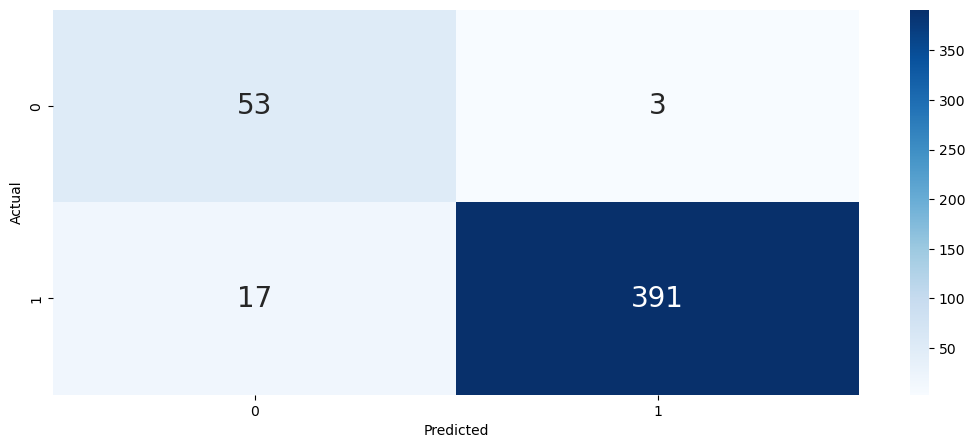

In [47]:
plt.figure(figsize=(13,5))
sns.heatmap(matrix, annot=True, cmap="Blues", fmt='g', annot_kws={"size": 20})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Save Model

In [23]:
# Save the trained model as a .pkl file
dump(iso_forest, 'iso_forest_model.pkl')

['iso_forest_model.pkl']

## Test Predictions

In [24]:
# We'll leverage domain expertise to input test values for sensors known to fall within anomalous ranges

# Test data and column names
test_data = [40.3, 41.8, 39.8, 39.7, 5, 2, 75, 80]  
columns = ['t1', 't2', 't3', 't4', 'h3', 'h4', 'f1', 'f2']

# Convert test data into a pandas DataFrame
pred_df = pd.DataFrame([test_data], columns=columns)

# Load the previously saved model
model = open("iso_forest_model.pkl", "rb")
iso_forest_model = load(model)

# Make a prediction with the model
anomaly_prediction = iso_forest_model.predict(pred_df)

# Interpret the prediction
if anomaly_prediction == -1:
    print("The data is anomalous.")
else:
    print("The data is normal.")

The data is anomalous.
